# Preliminary results on BLM tests during last RHIC Au+Au run 

Loading libraries and definitions.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from datetime import datetime
import glob

# definitions
blm_col = {1:'blue', 2:'red', 3:'darkgreen'}
ch_label = {1:'CVD', 2:'Cividec', 3:'Powder Prism'}
local_fontsize = 12


## Collecting data files and make DataFrames:
- CSVs with peaks from BLM:
    - open
    - concatinate
    - clean

In [ ]:
# Find all CSV files in the folder
csv_files = glob.glob('../Data/CIVIDEC/peaks_2025-*.csv')
# Read and concatenate CSVs
dfs = [pd.read_csv(f) for f in csv_files]
df_ini = pd.concat(dfs, ignore_index=True)
date_string = '2025_0716-0724' 

use_dates = '2025_0716-0724'

# Preview the first few rows
print(1,df_ini[df_ini['ch']==1].head())
print(2,df_ini[df_ini['ch']==2].head())
print(3,df_ini[df_ini['ch']==3].head())

# Array-like columns
array_cols = ['peak_indicies', 'peak_heights', 'widths', 'dist_to_revsig', 'integrals']

# Parse the strings into lists
def parse_array_str(s):
    if not isinstance(s, str):
        return []
    s = s.strip('[]').strip()
    if not s:
        return []
    return s.split()

for col in array_cols:
    df_ini[col] = df_ini[col].apply(parse_array_str)

# Clean and align arrays row-by-row
def clean_row(row):
    arrays = {col: row[col] for col in array_cols}
    
    # Mark valid indices based on whether 'peak_indicies' are integers
    valid_indices = []
    for i, val in enumerate(arrays['peak_indicies']):
        try:
            int(val)
            valid_indices.append(i)
        except ValueError:
            continue

    # Now filter each array to keep only valid indices
    for col in array_cols:
        arr = arrays[col]
        arrays[col] = [arr[i] for i in valid_indices if i < len(arr)]

    # Optional: convert to int/float
    try:
        arrays['peak_indicies'] = [int(x) for x in arrays['peak_indicies']]
    except:
        arrays['peak_indicies'] = []
    try:
        arrays['peak_heights'] = [float(x) for x in arrays['peak_heights']]
        arrays['widths'] = [float(x) for x in arrays['widths']]
        arrays['dist_to_revsig'] = [float(x) for x in arrays['dist_to_revsig']]
        arrays['integrals'] = [float(x) for x in arrays['integrals']]
    except:
        pass  # You can choose to drop or log here

    # Return updated row
    for col in array_cols:
        row[col] = arrays[col]
    return row

# Apply row cleaning
df_ini = df_ini.apply(clean_row, axis=1)

# Explode each of those columns simultaneously
# First, ensure that each list in array columns has the same length per row
assert all(
    (df_ini[array_cols[0]].str.len() == df_ini[col].str.len()).all()
    for col in array_cols[1:]
), "Array columns have differing lengths within rows!"

# Explode the dataframe by repeating rows for each element in the arrays
df = df_ini.explode(array_cols).reset_index(drop=True)

# Cleaning bad timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
bad_timestamps = df[df['timestamp'].isna()]
print("Bad timing: ",bad_timestamps)
# Correct for computer time bias (-4 hours)
df['timestamp'] = df['timestamp'] - pd.Timedelta(hours=4)

# Convert peak_heights to numeric if it's string/object
df['peak_heights'] = pd.to_numeric(df['peak_heights'], errors='coerce')

# Group by channel
df['dist_to_revsig_ns'] = -1*df['dist_to_revsig'] * 1.0/df['sample_rate'] * 1e9

print(df[df['ch']==1].head)
print(df[df['ch']==2].head)
print(df[df['ch']==3].head)


1    ch peak_indicies  peak_heights        widths dist_to_revsig     integrals  \
0   1      [500001]  [0.06995885]         [2.9]        [-5345]  [0.10699588]   
1   1      [500001]  [0.10699588]   [2.9532967]        [-3351]  [0.20987654]   
2   1      [500001]  [0.20164609]  [2.82615385]       [-12614]  [0.36419753]   
3   1      [500001]  [0.10288066]  [3.12820513]       [-15412]  [0.22427984]   
4   1      [500003]  [0.52263374]  [3.67222222]        [-3677]  [1.03909465]   

                    timestamp   sample_rate  buffer_size  trigger_chn  \
0  2025-11-13T12:54:56.058051  1.500000e+09      1000000            1   
1  2025-11-13T12:54:56.445931  1.500000e+09      1000000            1   
2  2025-11-13T12:54:56.965642  1.500000e+09      1000000            1   
3  2025-11-13T12:54:57.694582  1.500000e+09      1000000            1   
4  2025-11-13T12:54:58.095720  1.500000e+09      1000000            1   

   trigger_level  
0          0.051  
1          0.051  
2          0.051  
3 

- Data files from beam monitoring

In [86]:
#------------ Read RHIC data with combining date/time

# Define files to load with their respective column names and filename patterns
file_info = {
    'current':      (['Date', 'Time', 'bluDCCTtotal', 'yelDCCTtotal', 'RhicState', 'Fill'], 'rhic_data_beamcurrent_*.dat'),
    'blm':          (['Date', 'Time', 'Array', 'Counts1', 'Counts2'], 'rhic_data_blm_*.dat'),
    'abort':        (['Date', 'Time', 'Abort'], 'rhic_data_abort_*.dat'),
    'blue_nemitx':  (['Date', 'Time', 'nEmit'], 'rhic_data_blue_emitx_*.dat'),
    'blue_nemity':  (['Date', 'Time', 'nEmit'], 'rhic_data_blue_emity_*.dat'),
    'yellow_nemitx':(['Date', 'Time', 'nEmit'], 'rhic_data_yellow_emitx_*.dat'),
    'yellow_nemity':(['Date', 'Time', 'nEmit'], 'rhic_data_yellow_emity_*.dat'),
    'start_ramp':   (['Date', 'Time', 'StartRamp'], 'rhic_data_startramp_*.dat'),
    'stop_ramp':    (['Date', 'Time', 'StopRamp'], 'rhic_data_endramp_*.dat'),
    'coll_sigma':   (None, 'rhic_data_collimators_716_72425.dat'),  # Special case: single file with complex datetime format
}

# Plot each scraper column separately with label
scraper_cols = [
    'blue_scraper0', 'blue_scraper1', 'blue_scraper2', 'blue_scraper3', 'blue_scraper4', 'blue_scraper5',
    'yellow_scraper0', 'yellow_scraper1', 'yellow_scraper2', 'yellow_scraper3', 'yellow_scraper4', 'yellow_scraper5'
]

dfs = {}

for key, (columns, pattern) in file_info.items():
    files = glob.glob(f'../BEAM_RHIC_DATA/{pattern}')
    
    if not files:
        print(f"Warning: No files found for {key} with pattern {pattern}")
        dfs[key] = pd.DataFrame(columns=columns if columns else None)
        continue
    
    if key == 'coll_sigma':
        # Single file with datetime split over multiple columns — special parsing required
        df_raw = pd.read_csv(files[0], sep=r'\s+', comment='#', header=None, engine='python')
        # Combine first five columns to form full datetime string
        df_raw['Timestamp'] = pd.to_datetime(
            df_raw[0] + ' ' + df_raw[1] + ' ' + df_raw[2].astype(str) + ' ' + df_raw[3] + ' ' + df_raw[4].astype(str),
            format='%a %b %d %H:%M:%S %Y'
        )
        dfd = df_raw.drop(columns=[0, 1, 2, 3, 4])
        dfd.columns = scraper_cols + ['Timestamp']
        dfs[key] = dfd[['Timestamp'] + scraper_cols]
    
    else:
        # Concatenate multiple files and parse combined Date and Time into Timestamp
        dfs[key] = pd.concat([
            pd.read_csv(file, sep=r'\s+', comment='#', header=None, names=columns)
            for file in files
        ], ignore_index=True)
        dfs[key]['Timestamp'] = pd.to_datetime(dfs[key]['Date'] + ' ' + dfs[key]['Time'], format='%m/%d/%Y %H:%M:%S')

# Define columns to keep and reorder, dropping unnecessary ones
columns_to_keep = {
    'current':       ['Timestamp', 'bluDCCTtotal', 'yelDCCTtotal', 'RhicState', 'Fill'],
    'blm':           ['Timestamp', 'Counts1', 'Counts2'],
    'abort':         ['Timestamp', 'Abort'],
    'blue_nemitx':   ['Timestamp', 'nEmit'],
    'blue_nemity':   ['Timestamp', 'nEmit'],
    'yellow_nemitx': ['Timestamp', 'nEmit'],
    'yellow_nemity': ['Timestamp', 'nEmit'],
    'start_ramp':    ['Timestamp', 'StartRamp'],
    'stop_ramp':     ['Timestamp', 'StopRamp'],
    'coll_sigma':    ['Timestamp'] + scraper_cols,
}

for key, cols in columns_to_keep.items():
    dfd = dfs[key]
    # Drop 'Date', 'Time', and 'Array' if present, ignoring errors
    drop_cols = ['Date', 'Time'] + (['Array'] if key == 'blm' else [])
    dfd.drop(columns=drop_cols, inplace=True, errors='ignore')
    # Keep only relevant columns
    dfs[key] = dfd[cols].sort_values('Timestamp').reset_index(drop=True)


# Get separate DataFrames
df_current = dfs['current']
df_blm = dfs['blm']
df_abort = dfs['abort']
df_blue_nemitx = dfs['blue_nemitx']
df_blue_nemity = dfs['blue_nemity']
df_yellow_nemitx = dfs['yellow_nemitx']
df_yellow_nemity = dfs['yellow_nemity']
df_start_ramp = dfs['start_ramp']
df_stop_ramp = dfs['stop_ramp']
df_coll_sigma = dfs['coll_sigma']

print(f"\n[INFO] C-AD Beam intensity data: \n{df_current.head()}")
print(f"\n[INFO] C-AD BLM data: \n {df_blm.head()}")
print(f"\n[INFO] C-AD Abort data: \n {df_abort.head()}")
print(f"\n[INFO] C-AD Blue nEmitX data: \n {df_blue_nemitx.head()}")
print(f"\n[INFO] C-AD Blue nEmitY data: \n {df_blue_nemity.head()}")
print(f"\n[INFO] C-AD Yellow nEmitX data: \n {df_yellow_nemitx.head()}")
print(f"\n[INFO] C-AD Yellow nEmitY data: \n {df_yellow_nemity.head()}")
print(f"\n[INFO] C-AD Start Ramp data: \n {df_start_ramp.head()}")
print(f"\n[INFO] C-AD Stop Ramp data: \n {df_stop_ramp.head()}")
print(f"\n[INFO] C-AD Collimator Position in Sigma data: \n {df_coll_sigma.head()}")

df_start = df_start_ramp.copy()
df_end = df_stop_ramp.copy()


/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3197692390.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs[key] = pd.concat([
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3197692390.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs[key] = pd.concat([
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3197692390.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future ve


[INFO] C-AD Beam intensity data: 
            Timestamp  bluDCCTtotal  yelDCCTtotal RhicState   Fill
0 2025-07-01 00:00:00       166.896       171.510    store2  35701
1 2025-07-01 00:00:01       166.892       171.506    store2  35701
2 2025-07-01 00:00:02       166.887       171.503    store2  35701
3 2025-07-01 00:00:03       166.883       171.500    store2  35701
4 2025-07-01 00:00:04       166.878       171.496    store2  35701

[INFO] C-AD BLM data: 
             Timestamp  Counts1  Counts2
0 2025-07-01 00:00:00  1.31479  1.46052
1 2025-07-01 00:00:01  1.31479  1.46052
2 2025-07-01 00:00:02  1.31479  1.46052
3 2025-07-01 00:00:03  1.31479  1.46052
4 2025-07-01 00:00:04  1.31479  1.46052

[INFO] C-AD Abort data: 
             Timestamp Abort
0 2025-07-01 01:04:09    50
1 2025-07-01 10:32:19    50
2 2025-07-01 14:09:09    50
3 2025-07-01 17:11:24    50
4 2025-07-01 18:01:07    50

[INFO] C-AD Blue nEmitX data: 
             Timestamp    nEmit
0 2025-07-01 00:08:29  6.81972
1 2025-0

## Analysing Data

Rate of the dimond detectors was few Hz triggering was applied for signals from the detectors, not to collect to many empty events. Each channel was read for 2 min consequently, thus to calculate average rate averaging should be weather in 2 min range or more than 6 minutes and devided by 3 as there are 3 channels.

In [87]:
avg_min = 2 #data taking is N min each, should be >6 minutes
# Count occurrences per N minutes for each channel
counts = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),  # round timestamps to avg_min bins
    'ch'
]).size().reset_index(name='count')
# Group and compute mean peak_heights
avg_heights = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),
    'ch'
])['peak_heights'].mean().reset_index(name='avg_peak_height')

# Merge rate and average height by time + channel
combined = pd.merge(counts, avg_heights, on=['timestamp', 'ch'], how='left')
# Optional: calculate rate per minute (divide by avg_min)
counts['rate_per_min'] = counts['count'] / (avg_min/2)
counts['rate_per_sec'] = counts['count'] / (avg_min/2*60)
# Optional: calculate rate per minute (divide by avg_min)
combined['rate_per_min'] = combined['count'] / (avg_min/2)
combined['rate_per_sec'] = combined['count'] / (avg_min/2*60)

print(combined[combined['ch']==1].head())


            timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
0 2025-11-13 12:54:00   1    143         0.133730         143.0      2.383333
1 2025-11-13 12:56:00   1    103         0.142834         103.0      1.716667
3 2025-11-13 12:58:00   1    161         0.139560         161.0      2.683333
5 2025-11-13 13:00:00   1    101         0.141588         101.0      1.683333
7 2025-11-13 13:02:00   1    159         0.137511         159.0      2.650000


Lets see average rate versus amplitude:

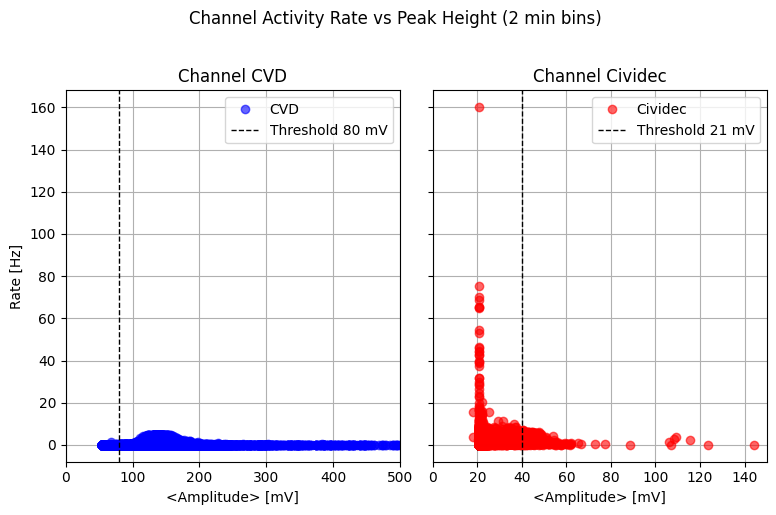

In [88]:
channels = combined['ch'].unique()
# Plotting the rate per second for each channel
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)
xlim = {1:500, 2:150}  # Set x-axis limits for each channel
for i, ch in enumerate(sorted(channels)):
    df_ch = combined[(combined['ch'] == ch) & (combined['rate_per_sec'] > 0)]
    axs[i].plot(1000*df_ch['avg_peak_height'], df_ch['rate_per_sec'],
                label=ch_label[ch],
                marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

    axs[i].set_xlabel('<Amplitude> [mV]')    
    axs[i].set_title(f'Channel {ch_label[ch]}')
    #axs[i].set_xscale('log')
    axs[i].set_xlim(0, xlim[ch])  # Set x-axis limit to 0-1000 mV
    axs[i].grid(True)
    #axs[i].legend()

axs[0].set_ylabel('Rate [Hz]')
# Draw vertical line at 80 mV on the first axis (axs[0])
axs[0].axvline(x=80, color='black', linestyle='--', linewidth=1, label='Threshold 80 mV')
axs[0].legend()
axs[1].legend()

# Draw vertical line at 2.25 on the last axis (axs[-1])
axs[-1].axvline(x=40, color='black', linestyle='--', linewidth=1, label='Threshold 21 mV')
axs[-1].legend()

plt.suptitle(f'Channel Activity Rate vs Peak Height ({avg_min} min bins)', y=1.02)
plt.tight_layout()
plt.savefig(f"./Plots/peak_heights_vs_rate_by_channel_{date_string}.png", dpi=300)
plt.show()

CVD diamond based BLM is showing high rate at low amplitudes some times, maybe it is related to collision background. Thus, we will implement lower threshold for CVD BLM at 80 mV and 2.25 mv for Quartz BLM. There is a structure in the rate, not clear what tis the source yet

In [89]:
df = df[
    ((df['peak_heights'] > 0.085) & (df['ch'] == 1)) |
    ((df['peak_heights'] > 0.0040) & (df['ch'] == 2)) 
]

Rate versus time:

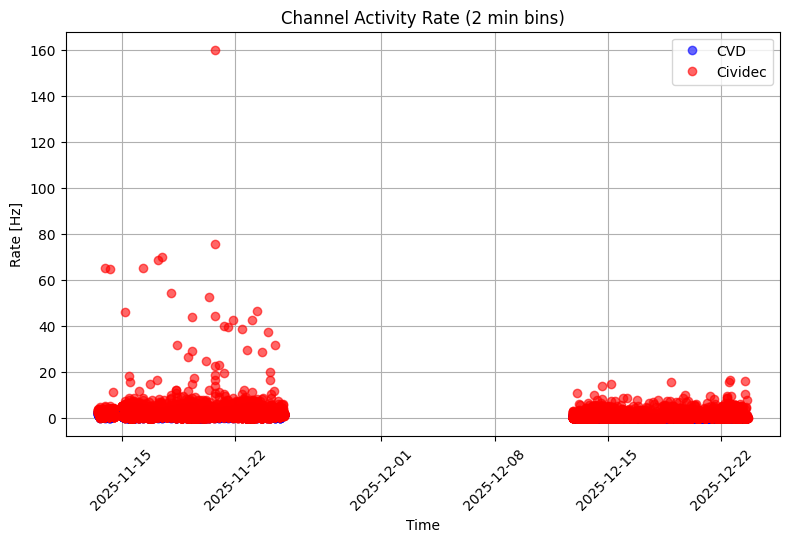

In [90]:
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():
    if ch==1:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.085)]
    if ch==2:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.0040)]
    plt.plot(df_ch['timestamp'], df_ch['rate_per_sec'], label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch],  alpha=0.6)

plt.xlabel('Time')
plt.ylabel('Rate [Hz]')
plt.title(f'Channel Activity Rate ({avg_min} min bins)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(f"./Plots/rate_vs_time_{date_string}.png", dpi=300)

plt.show()

Peak Height with respect to the beam revolution trigger:

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3920132058.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3920132058.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/amp_vs_revsig_{date_string}.png", dpi=300)
/Users/evgenyshulga/Work/EIC/BLM/rhic_blm_daq/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


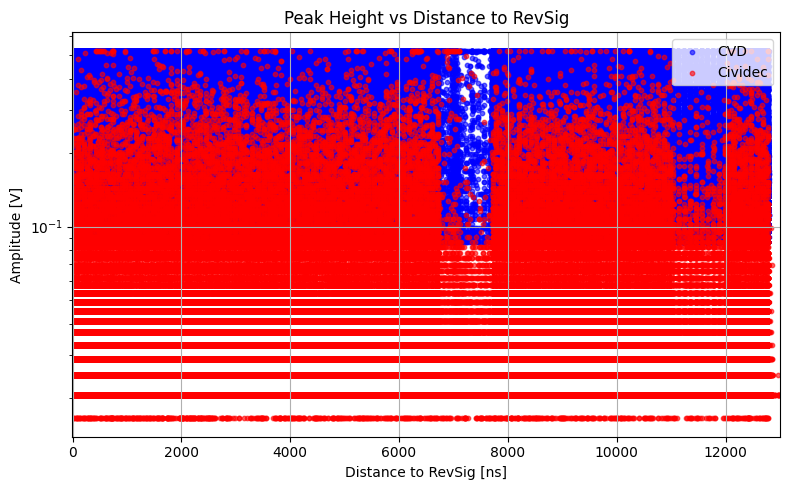

In [91]:
# Plot
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.scatter(df[df['ch']==ch]['dist_to_revsig_ns'], df[df['ch']==ch]['peak_heights'], color=blm_col[ch], label=ch_label[ch], s=10, alpha=0.6)
plt.xlabel('Distance to RevSig [ns]')
plt.ylabel('Amplitude [V]')
plt.title('Peak Height vs Distance to RevSig')
plt.grid(True)
plt.xlim(-1, 13000)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_revsig_{date_string}.png", dpi=300)

plt.show()


Amplitude versus time:

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/2929095602.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/2929095602.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)


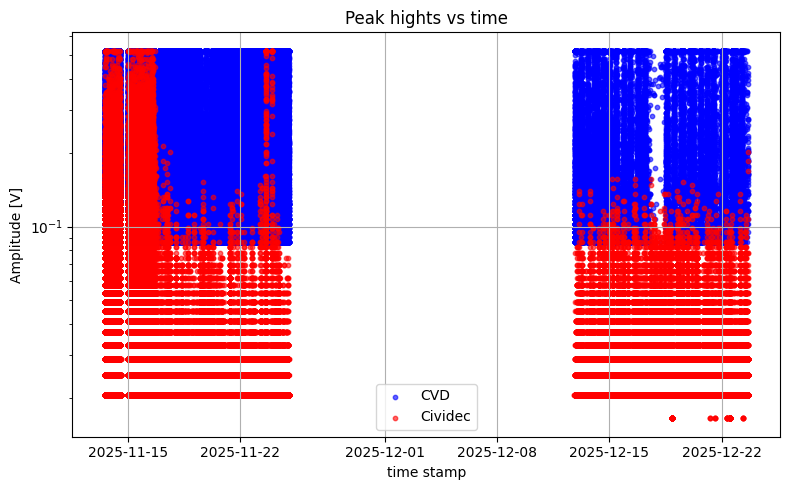

In [92]:
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.scatter(df[df['ch']==ch]['timestamp'], df[df['ch']==ch]['peak_heights'], color=blm_col[ch], label=ch_label[ch], s=10, alpha=0.6)
plt.xlabel('time stamp')
plt.ylabel('Amplitude [V]')
plt.title('Peak hights vs time')
plt.grid(True)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)

plt.show()


In [93]:
df_current = df_current.copy()
df_current['I_total'] = df_current['bluDCCTtotal'] + df_current['yelDCCTtotal']
df_current = df_current.sort_values('Timestamp').reset_index(drop=True)

df_stop = df_stop_ramp.sort_values('Timestamp').reset_index(drop=True)

df_stop_cur = pd.merge_asof(
    df_stop,
    df_current[['Timestamp', 'I_total']],
    on='Timestamp',
    direction='nearest',
    tolerance=pd.Timedelta('30s')  # adjust if needed
)

df_stop_cur = df_stop_cur.dropna(subset=['I_total'])

valid_stops = df_stop_cur[df_stop_cur['I_total'] > 200]

intervals = []

for stop_time in valid_stops['Timestamp']:

    # Only look AFTER stop_ramp
    df_after = df_current[df_current['Timestamp'] > stop_time]

    # First time current drops below 100
    drop = df_after[df_after['I_total'] < 100]

    if not drop.empty:
        drop_50_time = drop.iloc[0]['Timestamp']
        intervals.append((stop_time, drop_50_time))

To exclude contribution from unstable beam, selecting certain intensity intervals: 50<Intensity<210

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3085831254.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/3085831254.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort.png", dpi=300)
/Users/evgenyshulga/Work/EIC/BLM/rhic_blm_daq/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


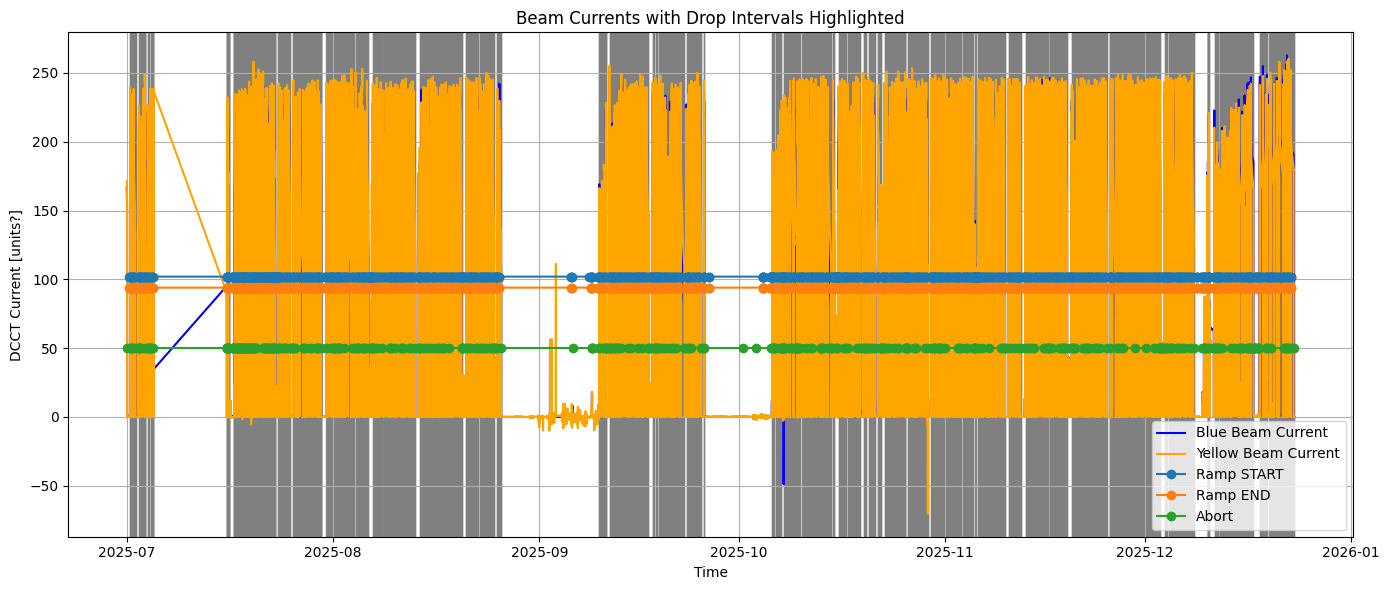

In [94]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_current['Timestamp'], df_current['bluDCCTtotal'], label='Blue Beam Current', color='blue')
plt.plot(df_current['Timestamp'], df_current['yelDCCTtotal'], label='Yellow Beam Current', color='orange')
plt.plot(df_start['Timestamp'], df_start['StartRamp'], label='Ramp START', marker='o', linestyle='-')
plt.plot(df_end['Timestamp'], df_end['StopRamp'], label='Ramp END', marker='o', linestyle='-')
plt.plot(df_abort['Timestamp'], df_abort['Abort'], label='Abort', marker='o', linestyle='-')
for start, end in intervals:#overlapping_intervals:
    plt.axvspan(start, end, color='gray', alpha=0.9)

# Convert list of dicts to DataFrame
intervals_df = pd.DataFrame(intervals,columns=['start','end'])

# Save to CSV
intervals_df.to_csv(f'stable_beam_intervals_{use_dates}.csv', index=False)

plt.xlabel("Time")
plt.ylabel("DCCT Current [units?]")
plt.title("Beam Currents with Drop Intervals Highlighted")
#plt.ylim(1e-2, 300)

#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort.png", dpi=300)

plt.show()

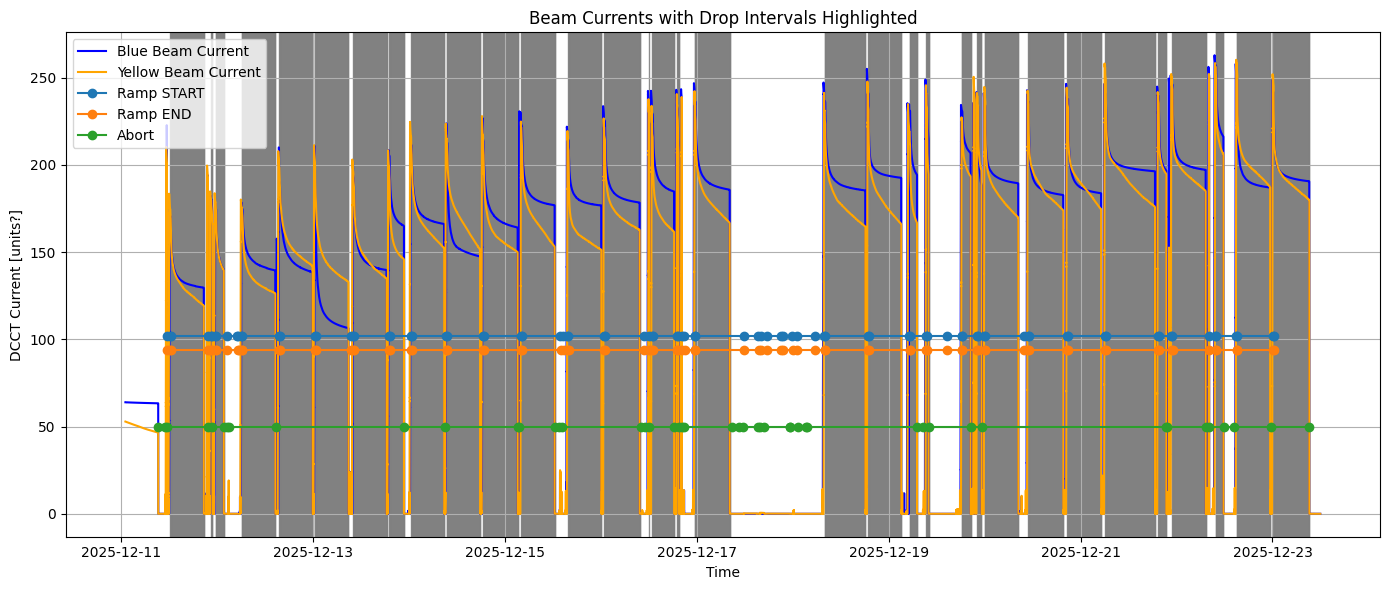

In [95]:
start_time = pd.to_datetime("2025-12-11 01:00:00")
end_time = pd.to_datetime("2025-12-23 14:00:00")
# Plotting
plt.figure(figsize=(14, 6))
selection_1 = ((df_current['Timestamp'] >= start_time) & (df_current['Timestamp'] <= end_time))
selection_start = ((df_start['Timestamp'] >= start_time) & (df_start['Timestamp'] <= end_time))
selection_end = ((df_end['Timestamp'] >= start_time) & (df_end['Timestamp'] <= end_time))
selection_abort = ((df_abort['Timestamp'] >= start_time) & (df_abort['Timestamp'] <= end_time))

plt.plot(df_current[selection_1]['Timestamp'], df_current[selection_1]['bluDCCTtotal'], label='Blue Beam Current', color='blue')
plt.plot(df_current[selection_1]['Timestamp'], df_current[selection_1]['yelDCCTtotal'], label='Yellow Beam Current', color='orange')
plt.plot(df_start[selection_start]['Timestamp'], df_start[selection_start]['StartRamp'], label='Ramp START', marker='o', linestyle='-')
plt.plot(df_end[selection_end]['Timestamp'], df_end[selection_end]['StopRamp'], label='Ramp END', marker='o', linestyle='-')
plt.plot(df_abort[selection_abort]['Timestamp'], df_abort[selection_abort]['Abort'], label='Abort', marker='o', linestyle='-')
for start, end in intervals:#overlapping_intervals:
    if start >= start_time and end <= end_time:
        plt.axvspan(start, end, color='gray', alpha=0.9)

## Convert list of dicts to DataFrame
#intervals_df = pd.DataFrame(intervals,columns=['start','end'])
#
## Save to CSV
#intervals_df.to_csv(f'stable_beam_intervals_{use_dates}.csv', index=False)

plt.xlabel("Time")
plt.ylabel("DCCT Current [units?]")
plt.title("Beam Currents with Drop Intervals Highlighted")
#plt.ylim(1e2, 200)

#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort_zoom.png", dpi=300)

plt.show()

Using only stable beam conditions:

In [96]:
# Load your main data (assuming it's already in variable df)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load the intervals CSV
intervals = pd.read_csv(f'./stable_beam_intervals_{use_dates}.csv')
intervals['start'] = pd.to_datetime(intervals['start'])
intervals['end'] = pd.to_datetime(intervals['end'])
intervals['start_plus_30min'] = intervals['start'] + pd.Timedelta(minutes=30)
# Create a mask to keep only rows in df within any interval
mask = pd.Series(False, index=df.index)
mask_combined = pd.Series(False, index=combined.index)

for _, row in intervals.iterrows():
    mask |= (df['timestamp'] >= row['start']) & (df['timestamp'] <= row['end'])
    mask_combined |= (combined['timestamp'] >= row['start']) & (combined['timestamp'] <= row['end'])
    #mask |= (df['timestamp'] >= row['start']) & (df['timestamp'] <= row['start_plus_30min'])

# Filtered DataFrame
df = df[mask].copy()

#print(df_filtered)

# Flatten the dist_to_revsig values (assumes each cell is a list)
all_distances_1_filtered = df[(df['ch']==1 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_2_filtered = df[(df['ch']==2 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)


/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/1089507018.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_42193/1089507018.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)
/Users/evgenyshulga/Work/EIC/BLM/rhic_blm_daq/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


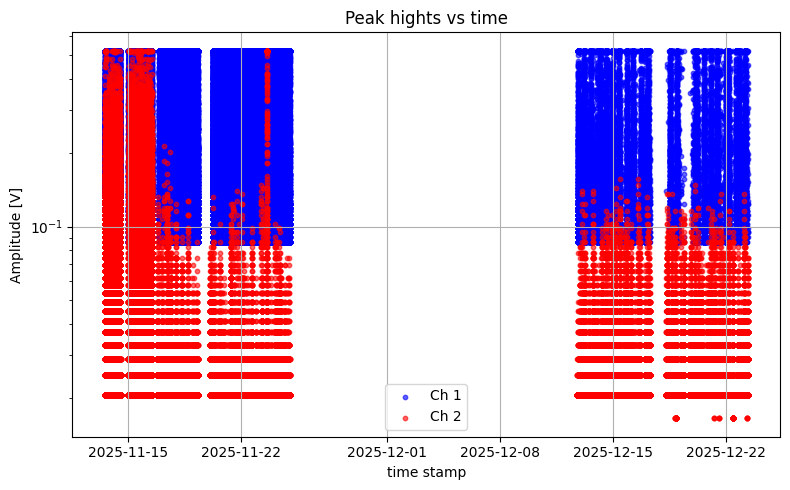

In [97]:
plt.figure(figsize=(8, 5))
        
plt.scatter(df[df['ch']==1]['timestamp'], df[df['ch']==1]['peak_heights'], color='blue', label=f"Ch 1", s=10, alpha=0.6)
plt.scatter(df[df['ch']==2]['timestamp'], df[df['ch']==2]['peak_heights'], color='red', label=f"Ch 2", s=10, alpha=0.6)
plt.xlabel('time stamp')
plt.ylabel('Amplitude [V]')
plt.title('Peak hights vs time')
plt.grid(True)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)

plt.show()

Amplitude distribution:

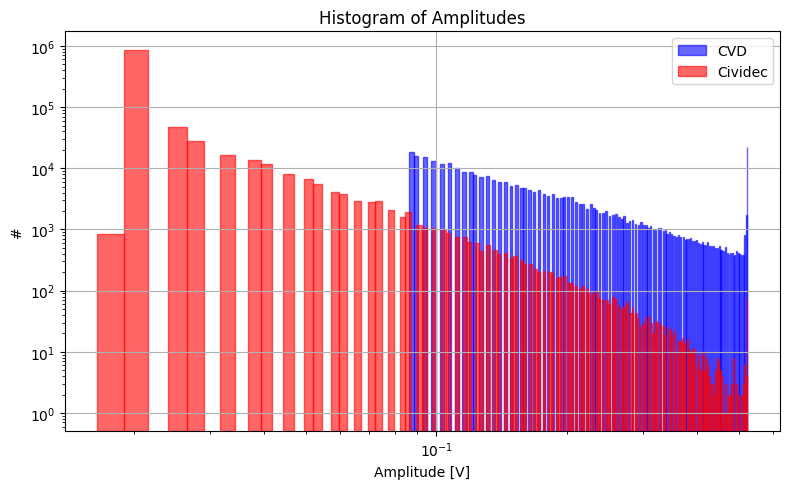

In [98]:
# Plot histogram
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.hist(df[df['ch']==ch]['peak_heights'], bins=200, color=blm_col[ch], edgecolor=blm_col[ch], label=ch_label[ch], alpha=0.6)

plt.xlabel('Amplitude [V]')
plt.ylabel('#')
plt.title('Histogram of Amplitudes')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_{date_string}.png", dpi=300)
plt.show()

To show time from beam revolution trigger to signal in the detector need to extract all distances

In [99]:
# Flatten the dist_to_revsig values (assumes each cell is a list)
all_distances_1 = df[(df['ch']==1 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_2 = df[(df['ch']==2 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)


Plot the timing:

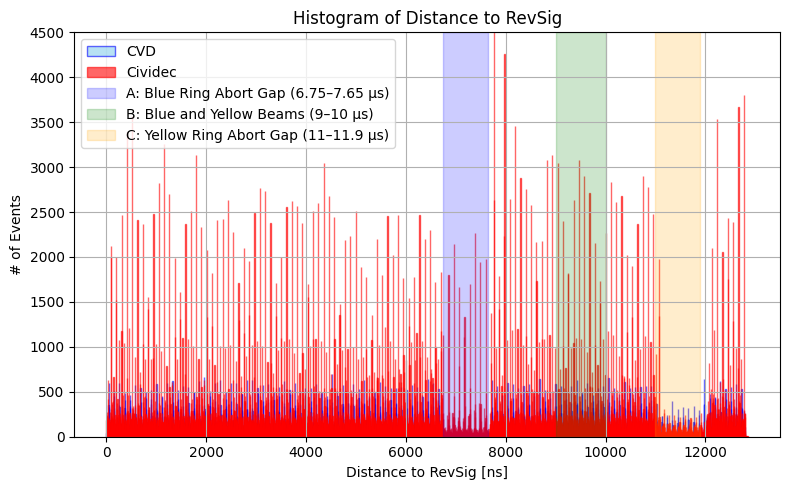

In [107]:
# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
plt.hist(all_distances_2, bins=4000, color='red'    , edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)

# Add shaded boxes for regions A, B, C (convert us to ns)
plt.axvspan(6.75e3, 7.65e3, color='blue',    alpha=0.2, label='A: Blue Ring Abort Gap (6.75–7.65 µs)')
plt.axvspan(9e3, 10e3,     color='green',   alpha=0.2,  label='B: Blue and Yellow Beams (9–10 µs)')
plt.axvspan(11e3, 11.9e3,   color='orange',  alpha=0.2, label='C: Yellow Ring Abort Gap (11–11.9 µs)')
plt.ylim(0, 4500)

plt.xlabel('Distance to RevSig [ns]')
plt.ylabel('# of Events')
plt.title('Histogram of Distance to RevSig')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}.png", dpi=300)

plt.show()

Zoom in:
- A: 6.75 to 7.6
5 microseconds

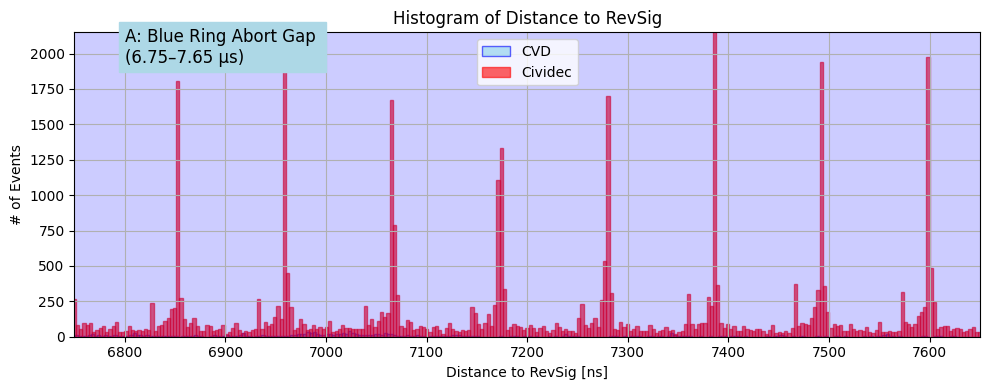

In [109]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10, 4))

# Plot histogram as usual
ax.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)

ax.set_xlim(6750, 7650)
ax.set_ylim(0, 2150)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((6750, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='blue', alpha=0.2)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(6800, ax.get_ylim()[1]*0.9, 'A: Blue Ring Abort Gap \n(6.75–7.65 µs)',
        fontsize=local_fontsize, color='black', backgroundcolor='lightblue')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_A.png", dpi=300)

plt.show()


- B: 10 to 11 microseconds

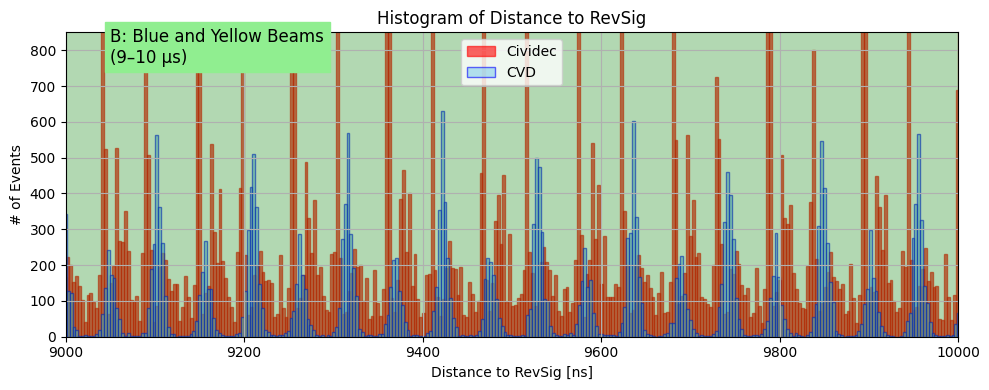

In [112]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10, 4))


# Plot histogram as usual
ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)

ax.set_xlim(9000, 10000)
ax.set_ylim(0, 850)

ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((9000, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='green', alpha=0.3)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(9050, ax.get_ylim()[1]*0.9, 'B: Blue and Yellow Beams\n(9–10 µs)',
        fontsize=local_fontsize, color='black', backgroundcolor='lightgreen')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_B.png", dpi=300)

plt.show()

- C: 11 to 11.9 microseconds

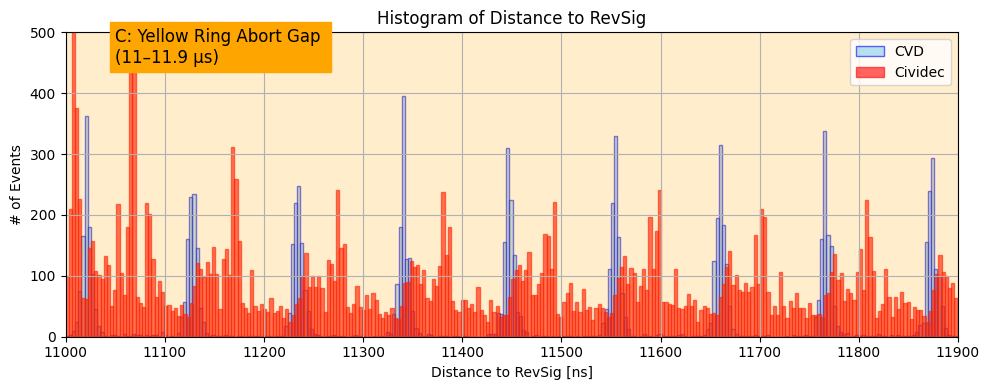

In [113]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10,4))

# Plot histogram as usual
ax.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)

ax.set_xlim(11e3, 11.9e3)
ax.set_ylim(0, 500)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((11e3, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='orange', alpha=0.2)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(11050, ax.get_ylim()[1]*0.9, 'C: Yellow Ring Abort Gap \n(11–11.9 µs)',
        fontsize=local_fontsize, color='black', backgroundcolor='orange')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_C.png", dpi=300)

plt.show()



At STAR IR the detectors see two abort gaps, one for blue and one for yellow beam. The Bunch spacing should be ~106 ns, we see signals from bunches every 106 ns. In addition we see signal every 50 ns, which do not correspond to Beam revolution trigger jitter or detector effects as we use 4 separate detector systems and 2 different readouts.

In [114]:
avg_min = 2 #data taking is N min each, should be >6 minutes
# Count occurrences per N minutes for each channel
counts = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),  # round timestamps to avg_min bins
    'ch'
]).size().reset_index(name='count')
# Group and compute mean peak_heights
avg_heights = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),
    'ch'
])['peak_heights'].mean().reset_index(name='avg_peak_height')

# Merge rate and average height by time + channel
combined = pd.merge(counts, avg_heights, on=['timestamp', 'ch'], how='left')

# Optional: calculate rate per minute (divide by avg_min)
counts['rate_per_min'] = counts['count'] / (avg_min/3)
counts['rate_per_sec'] = counts['count'] / (avg_min/3*60)
# Optional: calculate rate per minute (divide by avg_min)
combined['rate_per_min'] = combined['count'] / (avg_min/3)
combined['rate_per_sec'] = combined['count'] / (avg_min/3*60)

In [116]:
# Ensure Timestamp is datetime and set index
#df_current['Timestamp'] = pd.to_datetime(df_current['Timestamp'])
#df_current = df_current.set_index('Timestamp')

current = df_current['bluDCCTtotal']
intervals = []

i = 0
while i < len(current) - 1:
    # Find first drop below or equal to 200 from above
    if current.iloc[i] > 210 and current.iloc[i + 1] <= 210:
        drop_200_time = current.index[i + 1]

        # Now look forward for drop below or equal to 50
        j = i + 1
        while j < len(current) and current.iloc[j] > 50:
            j += 1
        if j < len(current):
            drop_50_time = current.index[j]
            intervals.append(
                (drop_200_time,
                drop_50_time)
            )
            i = j  # skip ahead to after this drop
        else:
            break
    else:
        i += 1


In [118]:
print(df_current.head())

                     bluDCCTtotal  yelDCCTtotal RhicState   Fill  I_total
Timestamp                                                                
2025-07-01 00:00:00       166.896       171.510    store2  35701  338.406
2025-07-01 00:00:01       166.892       171.506    store2  35701  338.398
2025-07-01 00:00:02       166.887       171.503    store2  35701  338.390
2025-07-01 00:00:03       166.883       171.500    store2  35701  338.383
2025-07-01 00:00:04       166.878       171.496    store2  35701  338.374


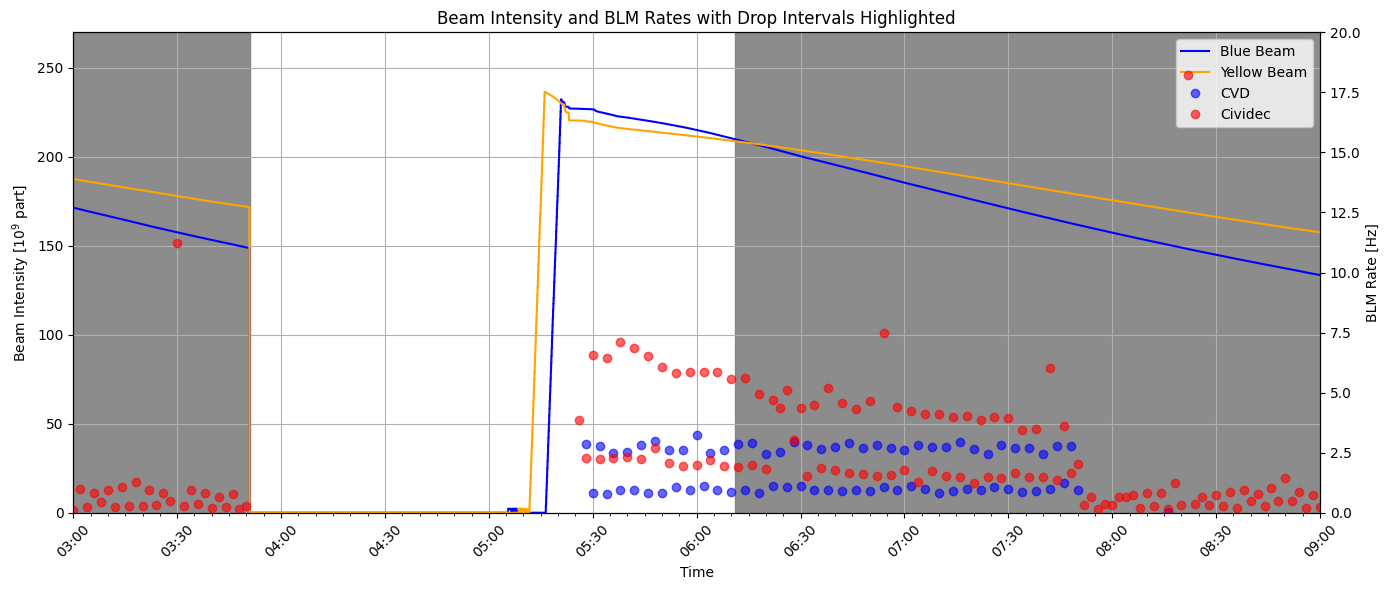

In [ ]:
#import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(14, 6))
start_time = pd.to_datetime("2025-11-20 03:00:00")
end_time = pd.to_datetime("2025-11-20 09:00:00")

# Left Y-axis (ax1) — Beam Current
ax1.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam', color='blue')
ax1.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam', color='orange')
ax1.set_ylabel(f'Beam Intensity [$10^{9}$ part]', color='black')

# Highlight intervals on ax1
for start, end in intervals:
    ax1.axvspan(start, end, color='gray', alpha=0.9)

# Right Y-axis (ax2) — Rate per sec
ax2 = ax1.twinx()

for ch in combined['ch'].unique():
    df_ch = combined[(combined['ch'] == ch) & (combined['rate_per_sec'] > 0)]
    ax2.plot(df_ch['timestamp'], df_ch['rate_per_sec'],
            label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch], alpha=0.6)


ax2.set_ylabel('BLM Rate [Hz]', color='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_xlim(start_time, end_time)
ax2.set_xlim(start_time, end_time)

# Time ticks
#ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
#ax1.tick_params(axis='x', rotation=45)


ax1.set_ylim(0, 270)
ax2.set_ylim(0, 20)
# X-axis and Title
ax1.set_xlabel("Time")
plt.title("Beam Intensity and BLM Rates with Drop Intervals Highlighted")
ax1.grid(True)

plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}.png", dpi=300)
plt.show()


            timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
0 2025-11-13 12:54:00   1     76         0.196285         114.0         1.900
1 2025-11-13 12:56:00   1     60         0.199246          90.0         1.500
2 2025-11-13 12:56:00   2    217         0.037777         325.5         5.425
3 2025-11-13 12:58:00   1     82         0.212687         123.0         2.050
4 2025-11-13 12:58:00   2    142         0.039819         213.0         3.550


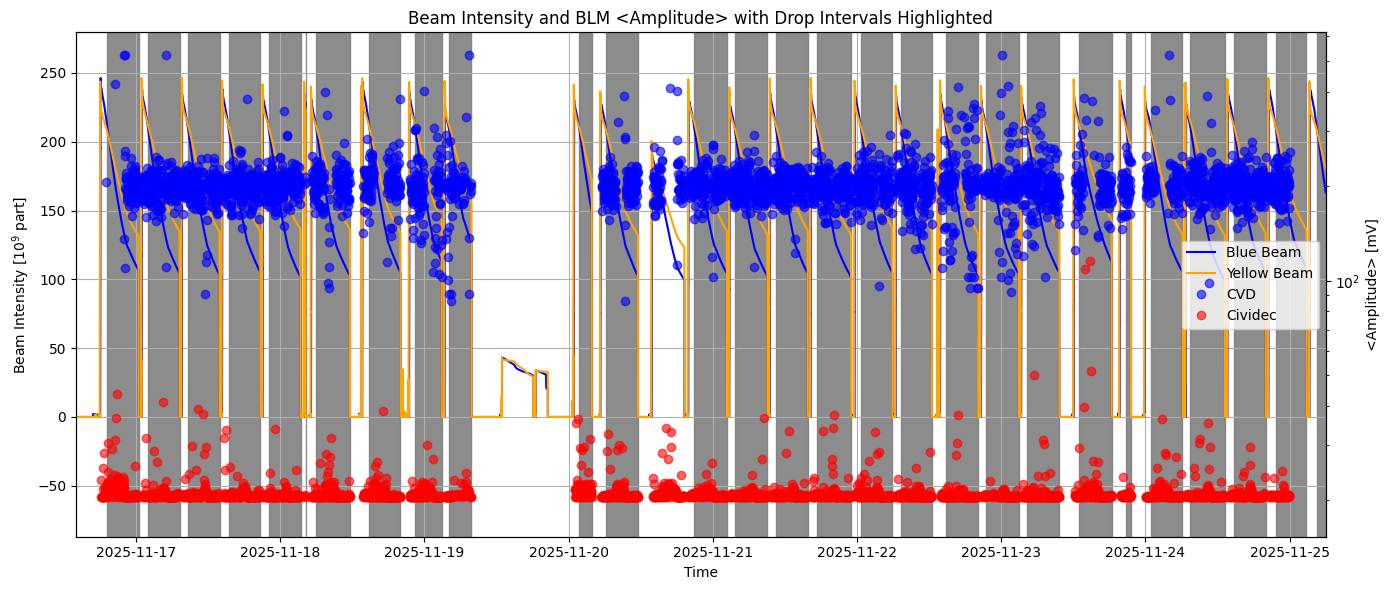

In [127]:
print(combined.head())
fig, ax1 = plt.subplots(figsize=(14, 6))
start_time = pd.to_datetime("2025-11-16 14:00:00")
end_time = pd.to_datetime("2025-11-25 06:00:00")

# Left Y-axis (ax1) — Beam Current
ax1.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam', color='blue')
ax1.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam', color='orange')
ax1.set_ylabel(f'Beam Intensity [$10^{9}$ part]', color='black')

# Highlight intervals on ax1
for start, end in intervals:
    ax1.axvspan(start, end, color='gray', alpha=0.9)

# Right Y-axis (ax2) — Rate per sec
ax2 = ax1.twinx()

for ch in combined['ch'].unique():
    df_ch = combined[(combined['ch'] == ch) & (combined['avg_peak_height'] > 0)]
    ax2.plot(df_ch['timestamp'], 1000*df_ch['avg_peak_height'],
             label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

ax2.set_ylabel('<Amplitude> [mV]', color='black')
# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

ax1.set_xlim(start_time, end_time)
ax2.set_xlim(start_time, end_time)

ax2.set_yscale('log')

# X-axis and Title
ax1.set_xlabel("Time")
plt.title("Beam Intensity and BLM <Amplitude> with Drop Intervals Highlighted")
ax1.grid(True)

plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_amp_{use_dates}.png", dpi=300)
plt.show()
